In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
models = ['bcc-csm1-1','CanESM2','CCSM4','CNRM-CM5','CSIRO-Mk3-6-0','GFDL-CM3','GISS-E2-R','HadGEM2-ES','inmcm4','IPSL-CM5A-LR','MIROC-ESM','MIROC5','MRI-CGCM3','NorESM1-M']

In [8]:
lon = 4.5
lat = 52.5

In [9]:
#Load grid and fingerprints
with xr.open_dataset('../data/fingerprints.nc') as ds:
    ds = ds.sel(lat=lat,lon=lon)
    fp_a = ds['fp_a'].values
    fp_gr = ds['fp_gr'].values
    fp_gl = ds['fp_gl'].values


In [16]:
def getcomponents(model,scen):
    comp = {}
    
    #Get ocean dynamics
    with xr.open_dataset(f'../rawdata/zos_hist/CorrectedZOS_EXPrcp85_{model}.nc') as ds:
        ds = ds.sel(time=slice(1901,2100),latitude=lat,longitude=lon)
        comp['odyn'] = ds['CorrectedZOS_reg'].values
        time = ds['time'].values

    with xr.open_dataset(f'../rawdata/zos/CorrectedZOS_EXP{scen}_{model}.nc') as ds:
        ds = ds.sel(latitude=lat,longitude=lon)
        comp['odyn'] = np.append(comp['odyn'],ds['CorrectedZOS_reg'].values,axis=0)
        time = np.append(time,ds['time'].values)

    #Get steric
    with xr.open_dataset(f'../data/steric/{model}_{scen}.nc') as ds:
        ds = ds.sel(time_lt=slice(1901,2100))
        comp['ster'] = ds['SLR_lt'].values

    #Get Antarctic dynamics
    with xr.open_dataset(f'../data/Adyn/{model}_{scen}.nc') as ds:
        ds = ds.sel(time_lt=slice(1901,2100))
        comp['adyn'] = ds['SLR_lt'].values*fp_a

    #Get Antarctic SMB
    with xr.open_dataset(f'../data/Asmb/{model}_{scen}.nc') as ds:  
        ds = ds.sel(time_lt=slice(1901,2100))
        comp['asmb'] = ds['SLR_lt'].values*fp_a

    #Get Greenland SMB
    with xr.open_dataset(f'../data/Gsmb/{model}_{scen}.nc') as ds:  
        ds = ds.sel(time_lt=slice(1901,2100))
        comp['gsmb'] = ds['SLR_lt'].values*fp_gr

    #Get glaciers
    for r in range(1,20):
        with xr.open_dataset(f'../data/glacier/{model}_{scen}_{r}.nc') as ds:
            ds = ds.sel(time_lt=slice(1901,2100))
            if r==1:
                comp['glac'] = ds['SLR_lt'].values*fp_gl[r-1]
            else:
                comp['glac'] += ds['SLR_lt'].values*fp_gl[r-1]

    #Get others
    with xr.open_dataset(f'../data/others/gdyn_{scen}.nc') as ds:
        ds = ds.sel(lat=lat,lon=lon)
        comp['gdyn'] = ds['SLR_lt'].values
    with xr.open_dataset(f'../data/others/grw.nc') as ds:
        ds = ds.sel(lat=lat,lon=lon)
        comp['grw'] = ds['SLR_lt'].values    
    with xr.open_dataset(f'../data/others/gia.nc') as ds:
        ds = ds.sel(lat=lat,lon=lon)
        comp['gia'] = ds['SLR_lt'].values

    return time,comp

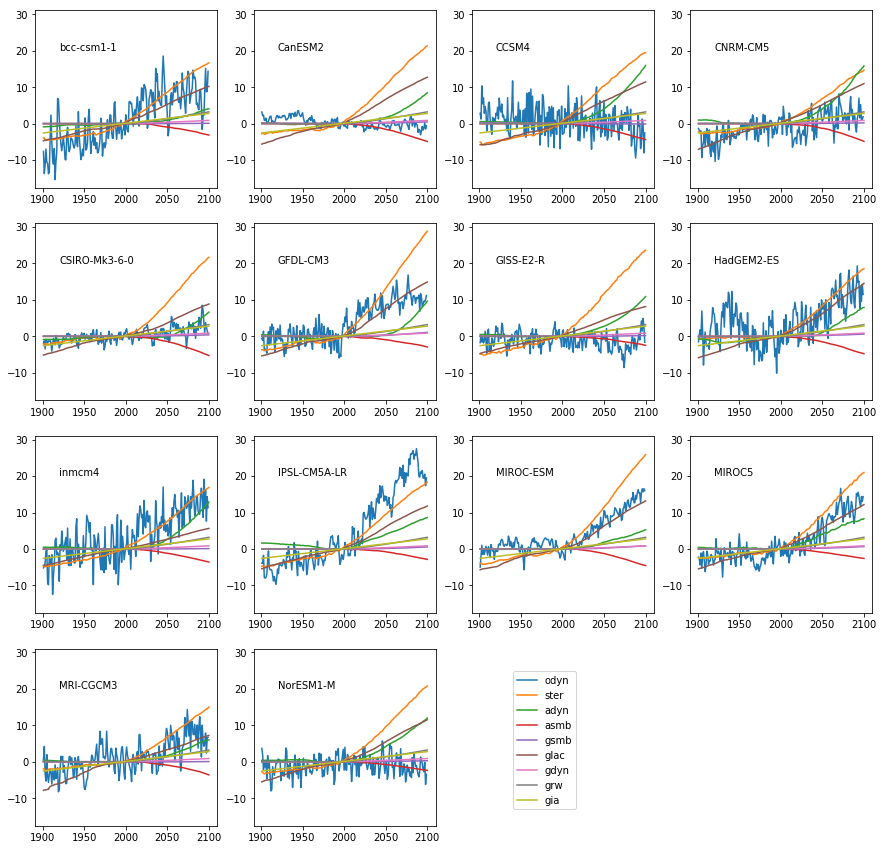

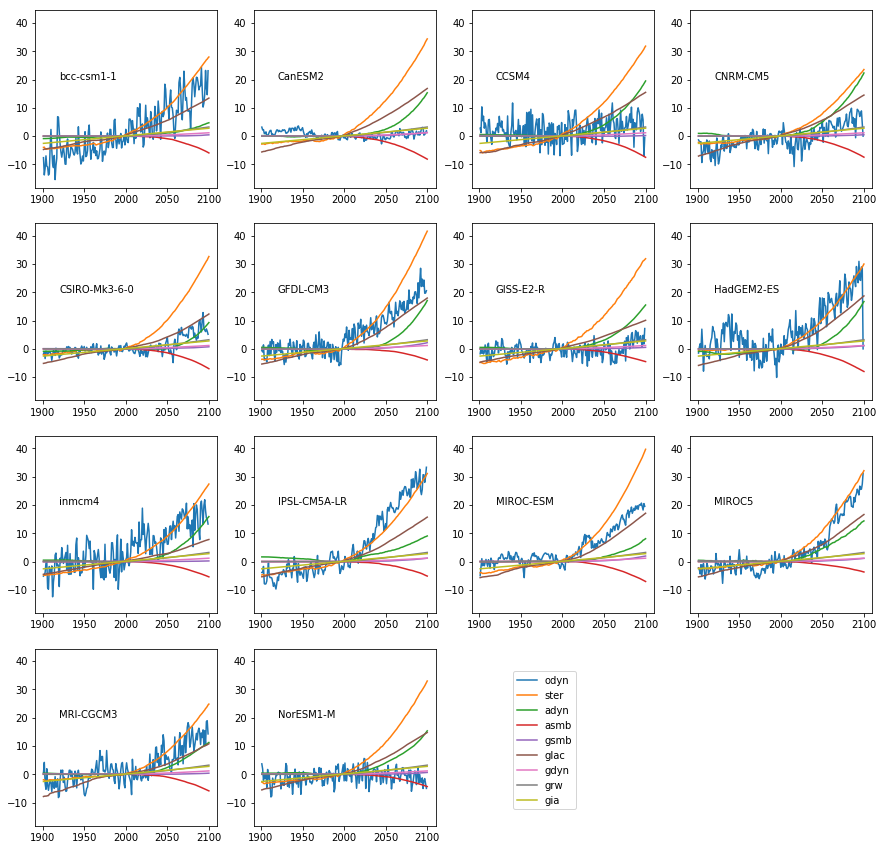

In [27]:
for scen in ['rcp45','rcp85']:
    fig = plt.figure(figsize=(15,15))

    for m,model in enumerate(models):
        if m==0:
            ax = fig.add_subplot(4,4,m+1)
        else:
            ax = fig.add_subplot(4,4,m+1,sharey=ax,sharex=ax)
        time,comp = getcomponents(model,scen)
        for c in comp.keys():
            ax.plot(time,comp[c],label=c)
        if m==len(models)-1:
            ax.legend(loc='upper right', bbox_to_anchor=(1.8, 0.9))
        ax.text(1920,20,model,ha='left')

    plt.savefig(f'nl_components_{scen}.png')
    plt.show()